# ***Libraries***

In [1]:
import math
import os
import sys
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from CUSUM import CUSUM

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
sys.path.append(parent_dir)

In [4]:
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length, plotFig, printResult

from TSB_UAD.models.sand import SAND

# ***Streaming Methods***

## ***Data Pre-Processing***

In [5]:
# Load the Time-Series dictionary
with open('Time-Series_Data_Dictionaries/Time-Series-Random-Data-of-Interest-Dictionary.json', 'r') as json_file:
    loaded_dict = json.load(json_file)

In [6]:
for filename, info in loaded_dict.items():
    print(f'{filename}: {info}')

ts1: ['Normality_1', 'SensorScope']
ts3: ['Normality_1', 'NASA-MSL']
ts4: ['Normality_1', 'YAHOO']
ts5: ['Normality_1', 'SMD']
ts8: ['Normality_1', 'SMD']
ts2: ['Normality_2', 'SensorScope', 'NAB']
ts9: ['Normality_2', 'Occupancy', 'NASA-MSL']
ts6: ['Normality_3', 'SensorScope', 'YAHOO', 'NASA-MSL']
ts7: ['Normality_3', 'YAHOO', 'NASA-MSL', 'SMD']


In [7]:
preprocessed_dict = {}

### ***Pre-processing for streaming methods***

In [11]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised methods
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1].astype(int)

    slidingWindow = find_length(data)
    X_data = Window(window=slidingWindow).convert(data).to_numpy()

    # Prepare data for semisupervised methods
    # The training ratio = 0.1

    """
    data_train = data[:int(0.1 * len(data))]
    data_test = data

    X_train = Window(window=slidingWindow).convert(data_train).to_numpy()
    X_test = Window(window=slidingWindow).convert(data_test).to_numpy()

    print(f'Time-Series filename: {filename}')
    print("Estimated Subsequence length: ", slidingWindow)
    print()
    """
    
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'slidingWindow': slidingWindow,
        'X_data': X_data,
        #'data_train': data_train,
        #'data_test': data_test,
        #'X_train': X_train,
        #'X_test': X_test,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

In [20]:
ts = pd.read_csv('/home/georgematlis/AUTH/DWS/MINING_FROM_MASSIVE_DATASETS/TSB-UAD/TSB-UAD-Public/TSB-UAD-Public/ECG/MBA_ECG805_data.out', header=None).dropna().to_numpy()

name = '/home/georgematlis/AUTH/DWS/MINING_FROM_MASSIVE_DATASETS/TSB-UAD/TSB-UAD-Public/TSB-UAD-Public/ECG/MBA_ECG805_data.out'.split('/')[-1]
max_length = 10000

data = ts[:max_length, 0].astype(float)
label = ts[:max_length, 1].astype(int)

slidingWindow = find_length(data)
X_data = Window(window=slidingWindow).convert(data).to_numpy()

0-->

/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->[STOP]: score length 10000


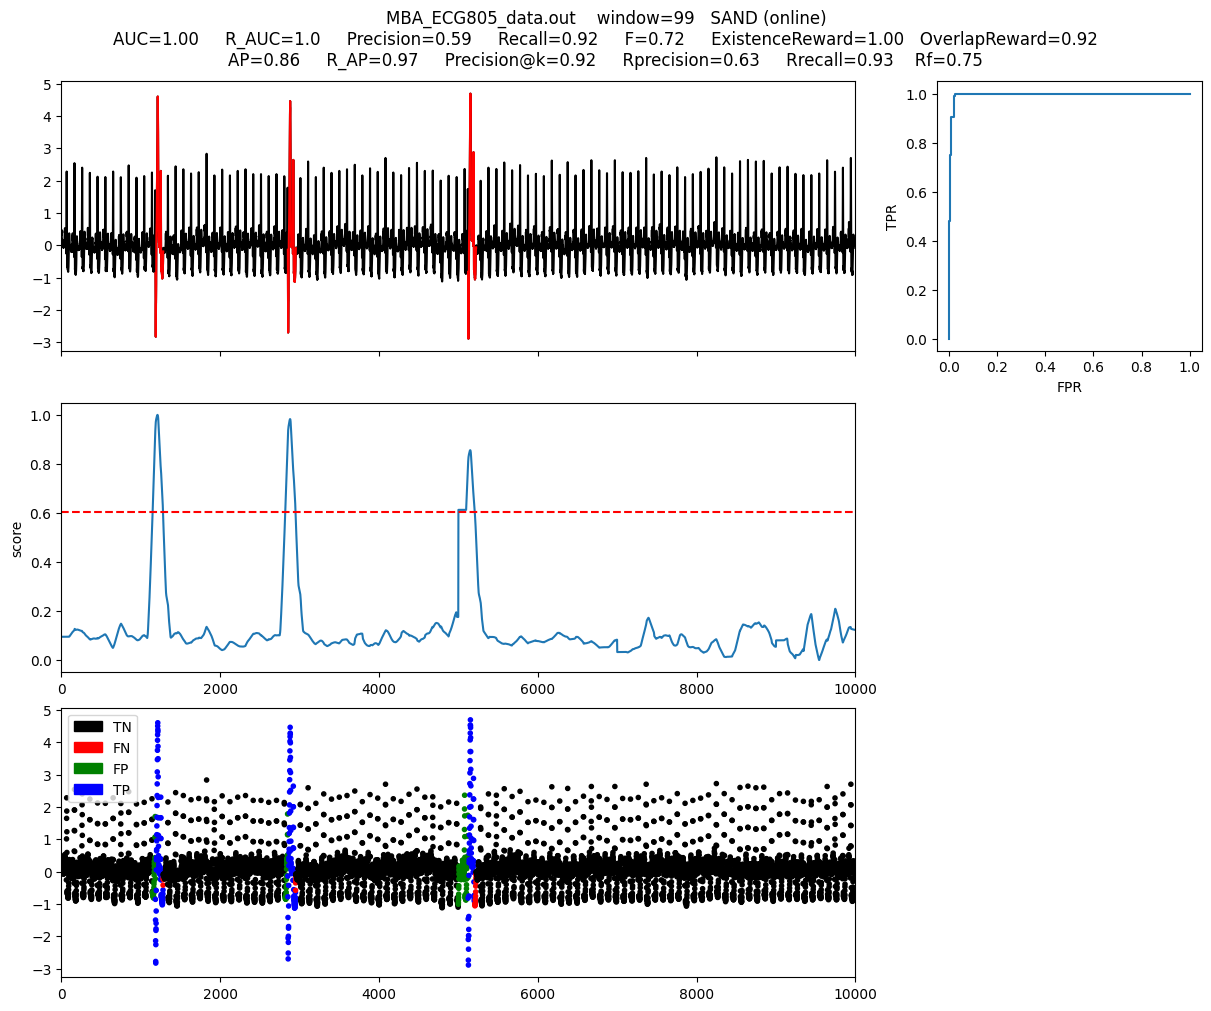

In [8]:
modelName='SAND (online)'
#clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
#clf.fit(x,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True,overlaping_rate=int(4*slidingWindow))
clf.fit(x,overlaping_rate=int(1.5*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

## ***Anomaly Detection***

Classification Information:
- TN: The point is normal and we predicted it is normal
- TP: The point is abnormal and we predicted it is abnormal
- FP: The point is normal and we predicted it is abnormal
- FN: The point is abnormal and we predicted it is normal

In [9]:
eval_metrics = ['AUC', 
                'Precision', 
                'Recall', 
                'F', 
                'Rrecall', 
                'ExistenceReward',
                'OverlapReward',
                'Rprecision',
                'Rf',
                'Precision@k',
                'R_AUC']

In [10]:
def highlight_diff(val):
    color = ''
    if val > 0:
        color = 'background-color: lightgreen'
    elif val < 0:
        color = 'background-color: lightcoral'
    return color

### ***SAND(Original)***

In [14]:
modelName = 'SAND'

/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
/home/georgematlis/anaconda3/envs/TSB/lib/python3.8/site-packages/sklearn/utils/validation.py:931

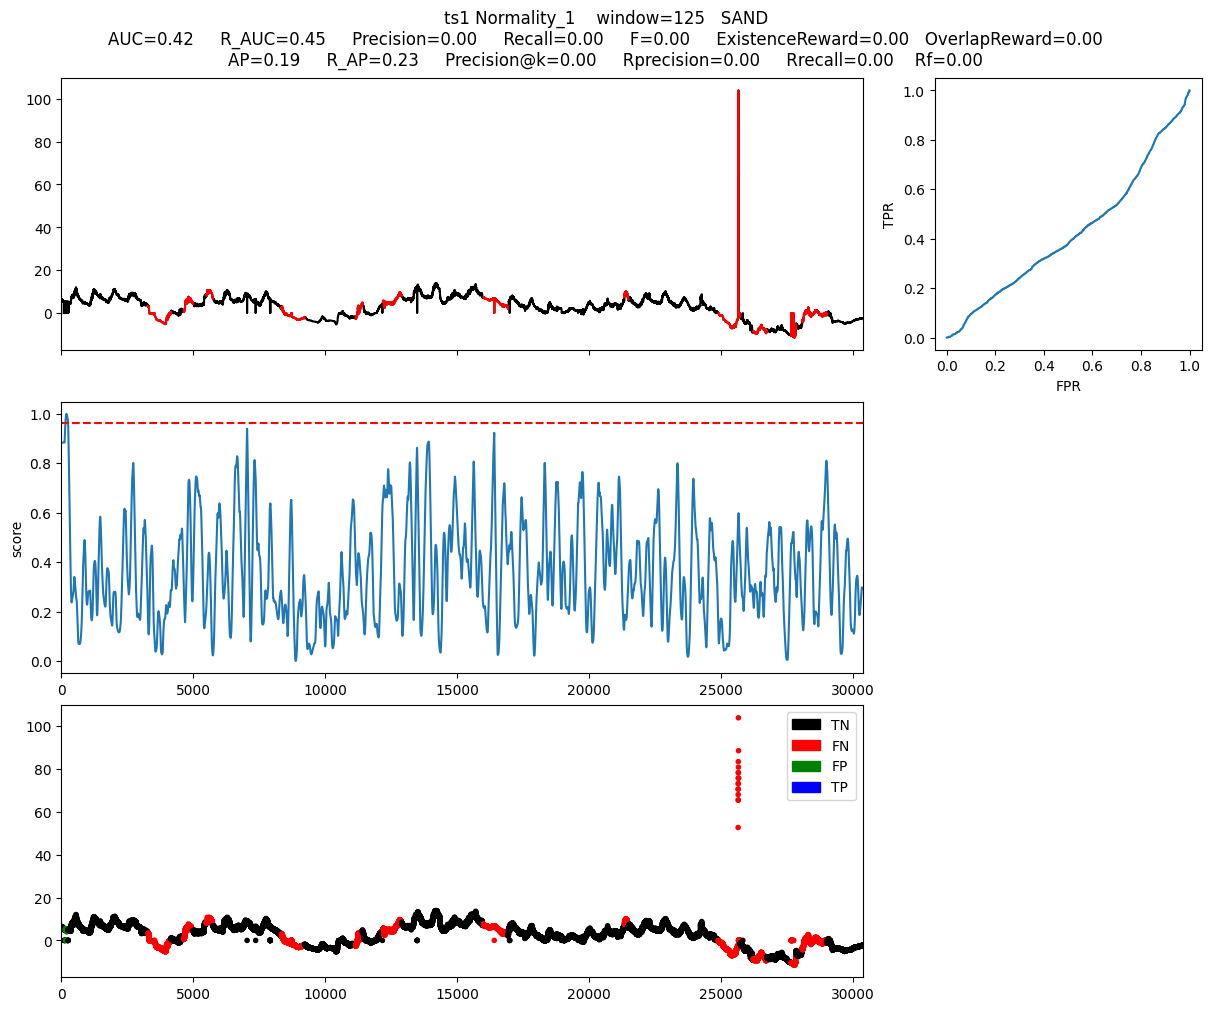

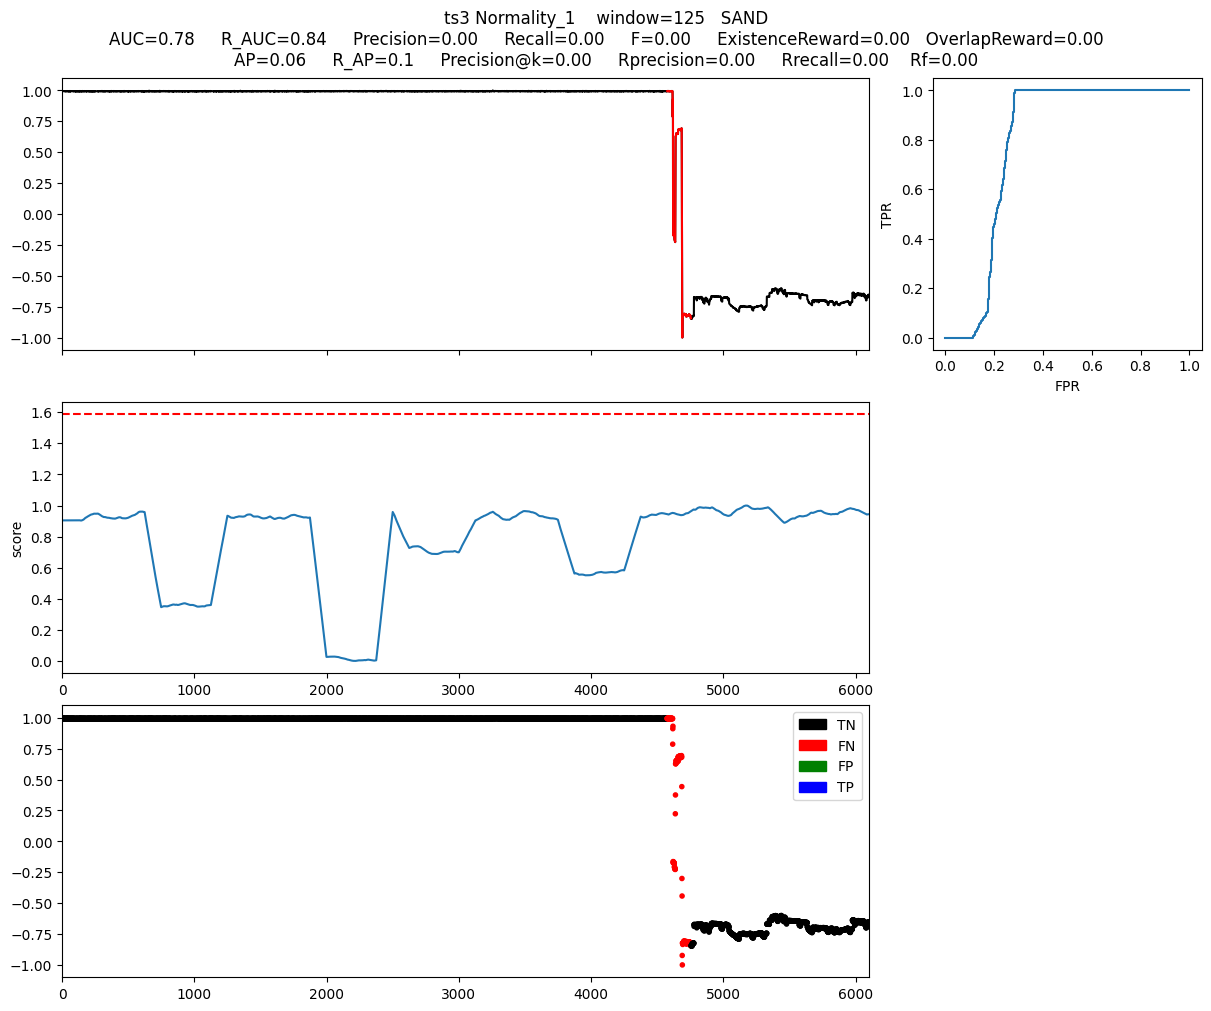

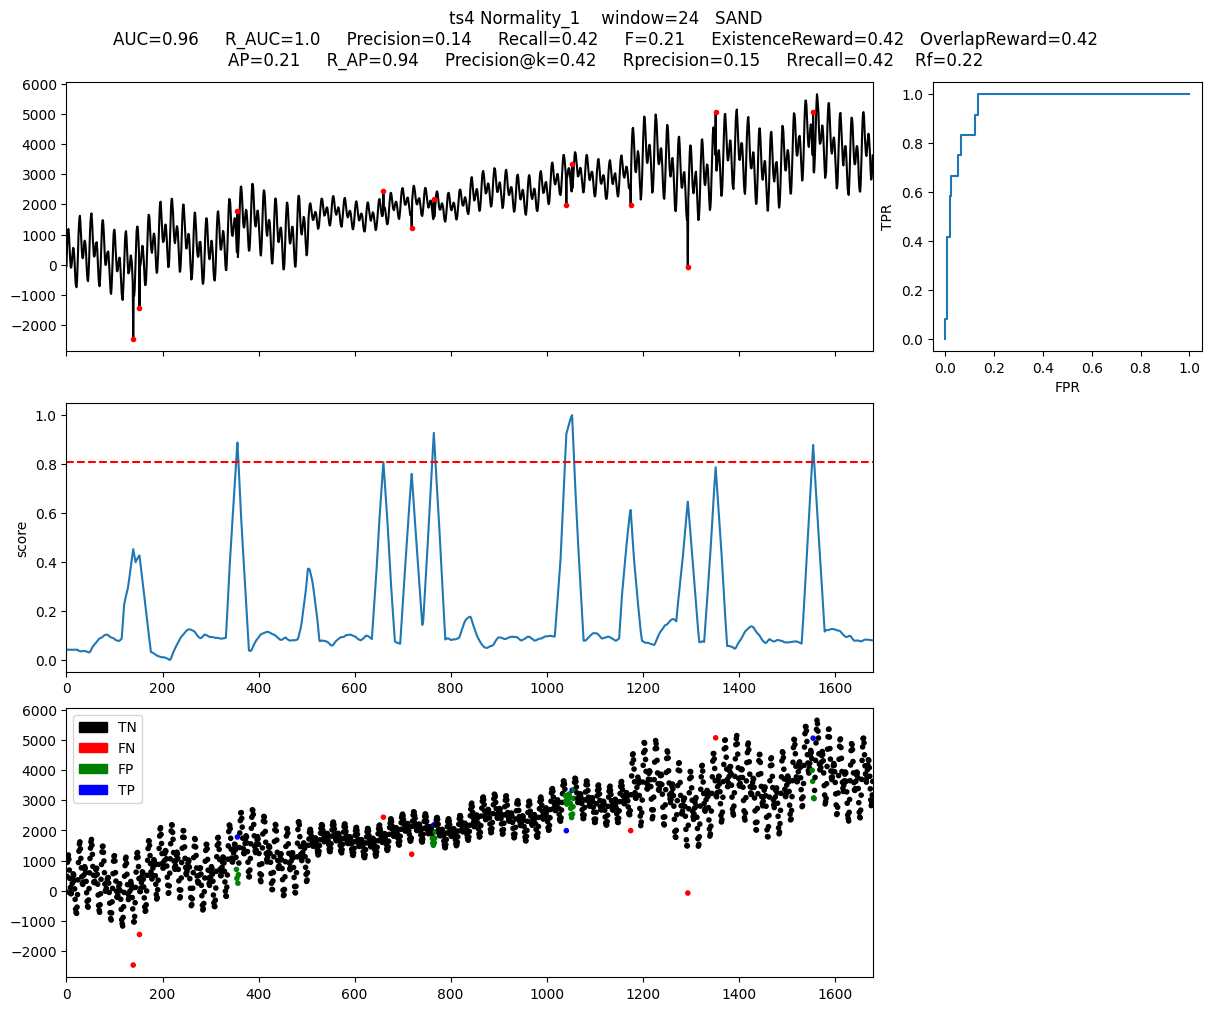

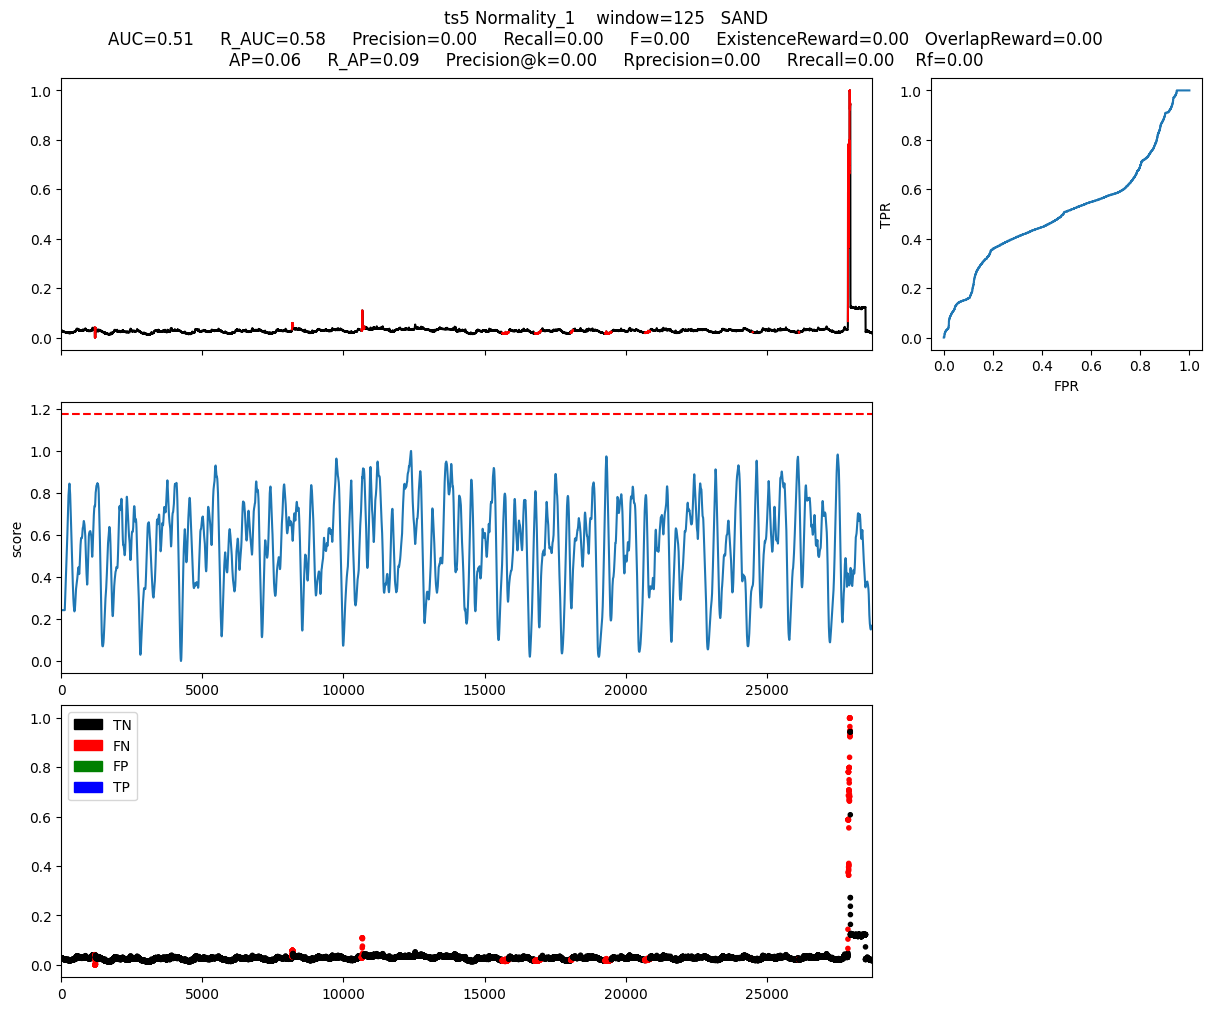

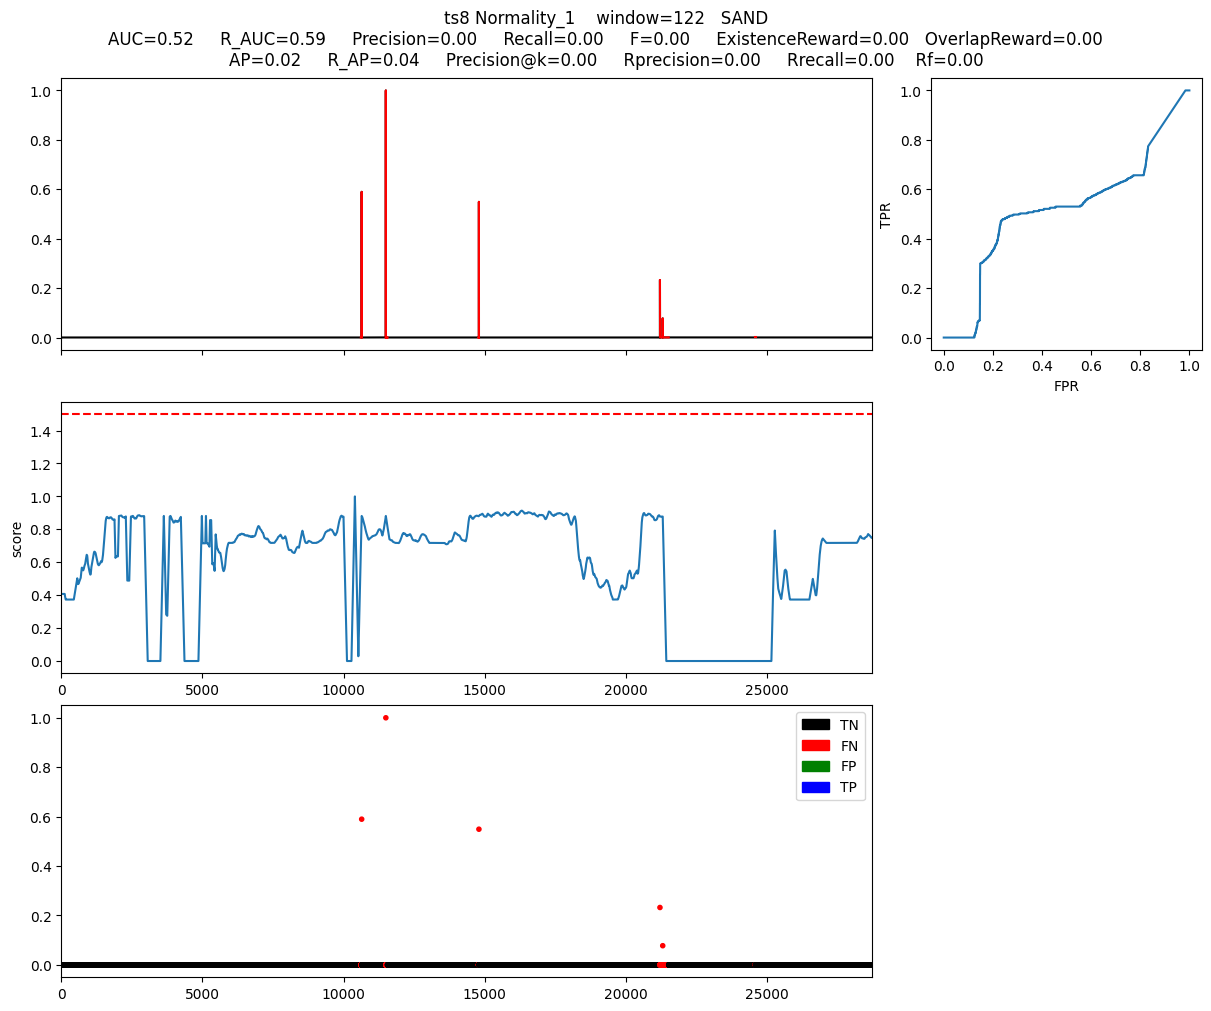

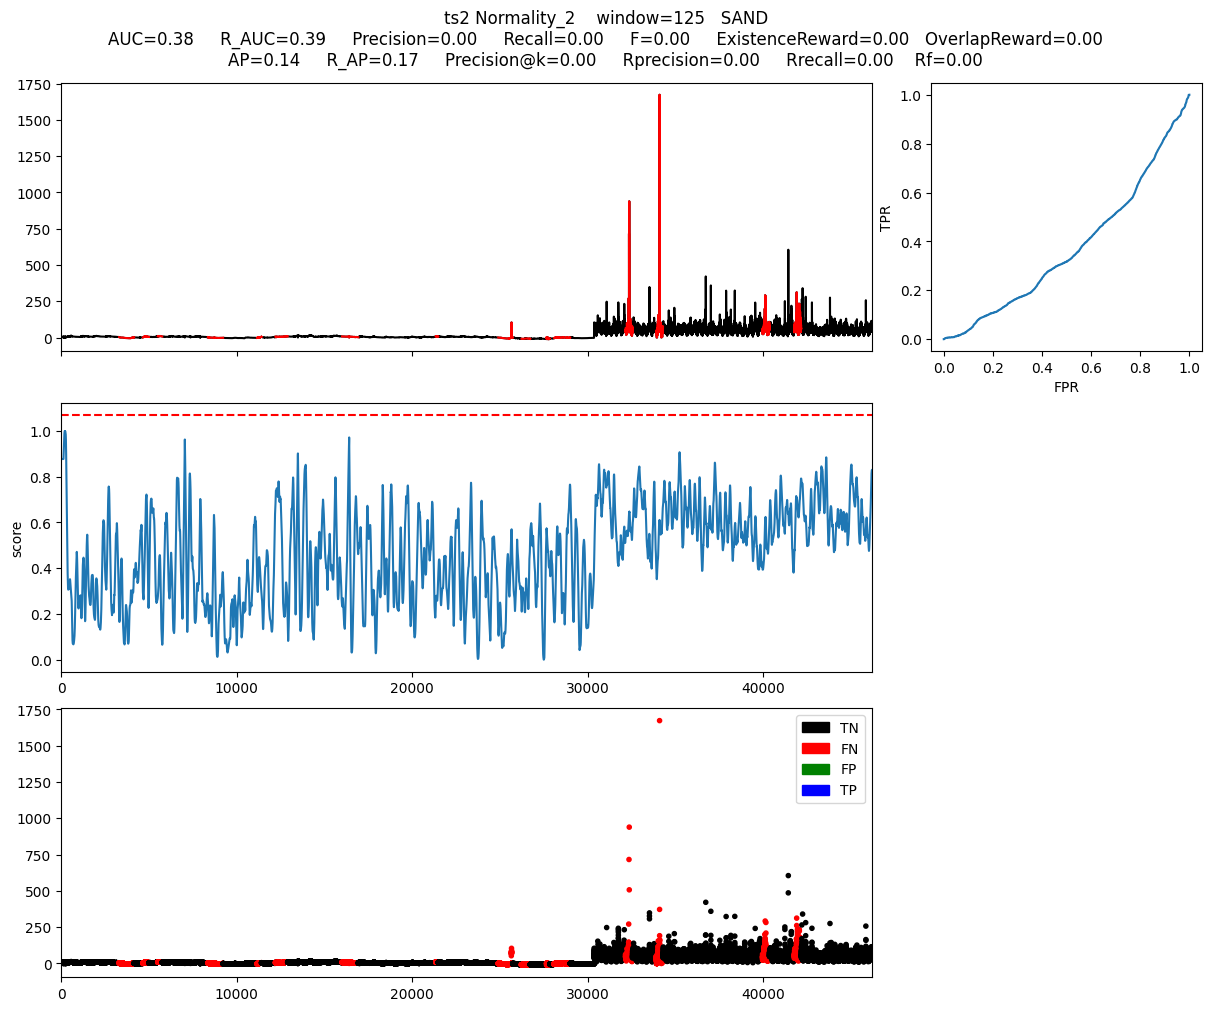

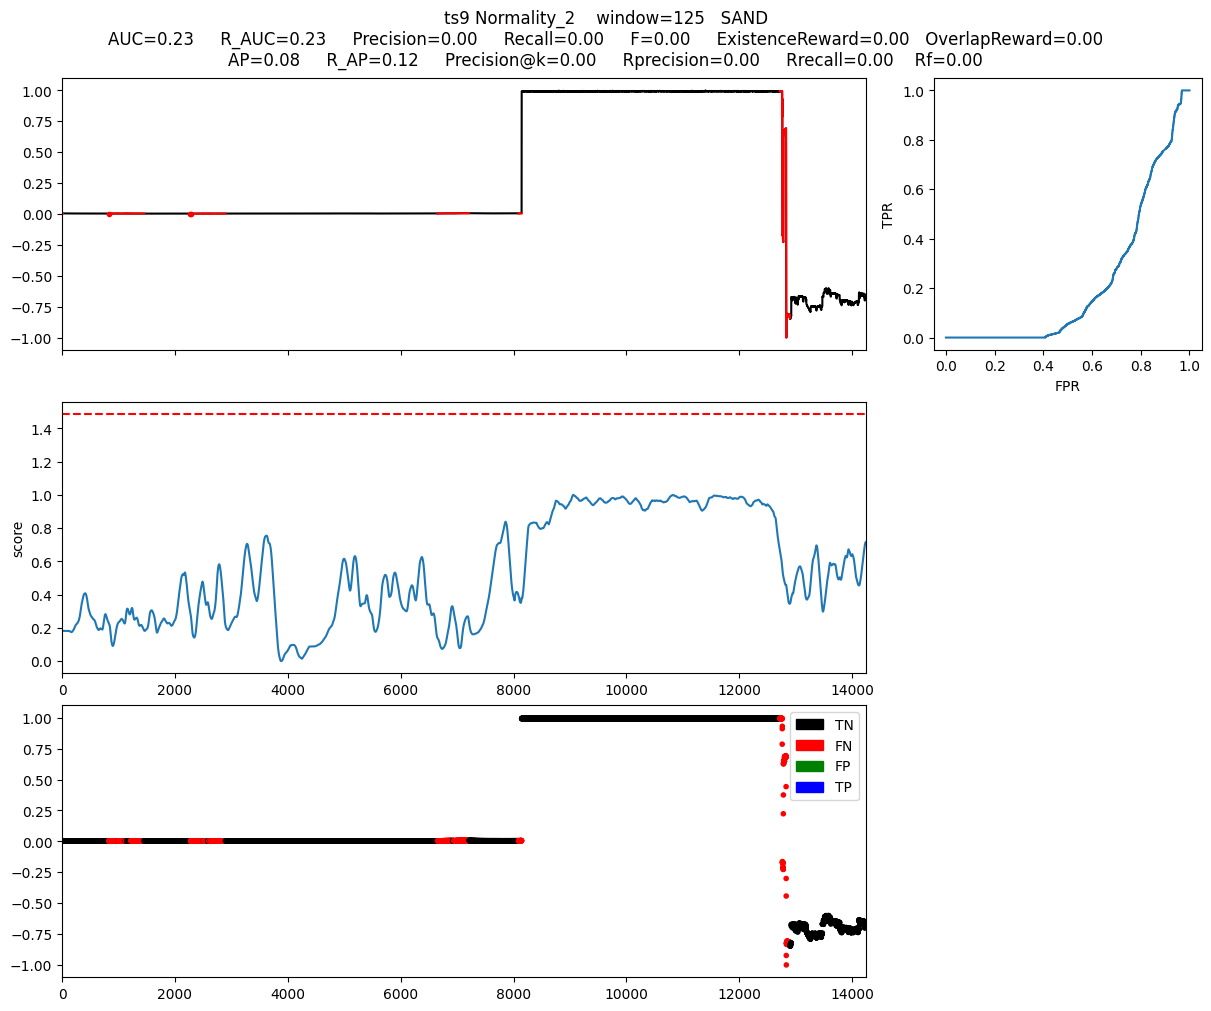

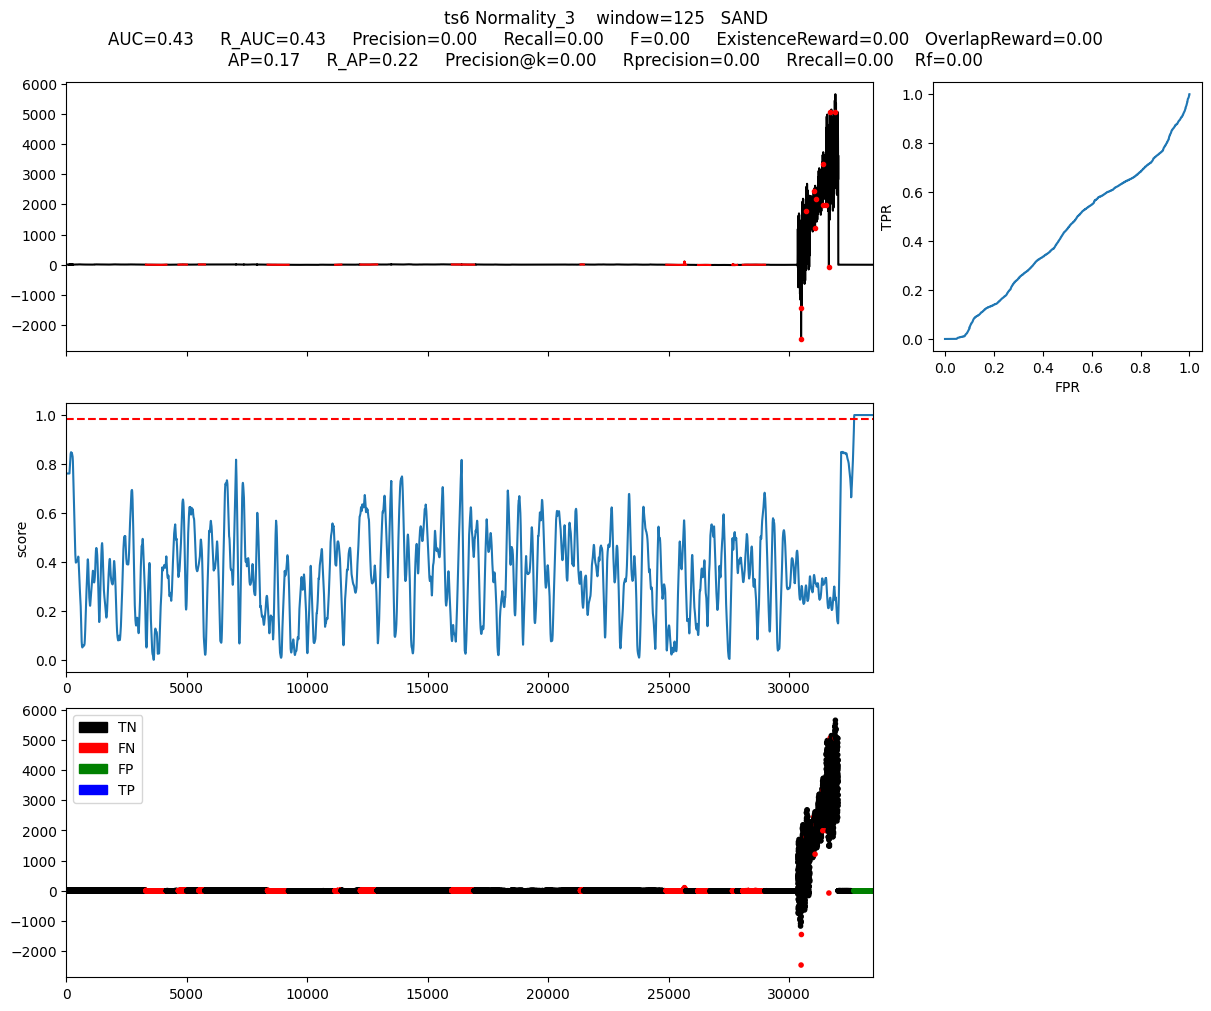

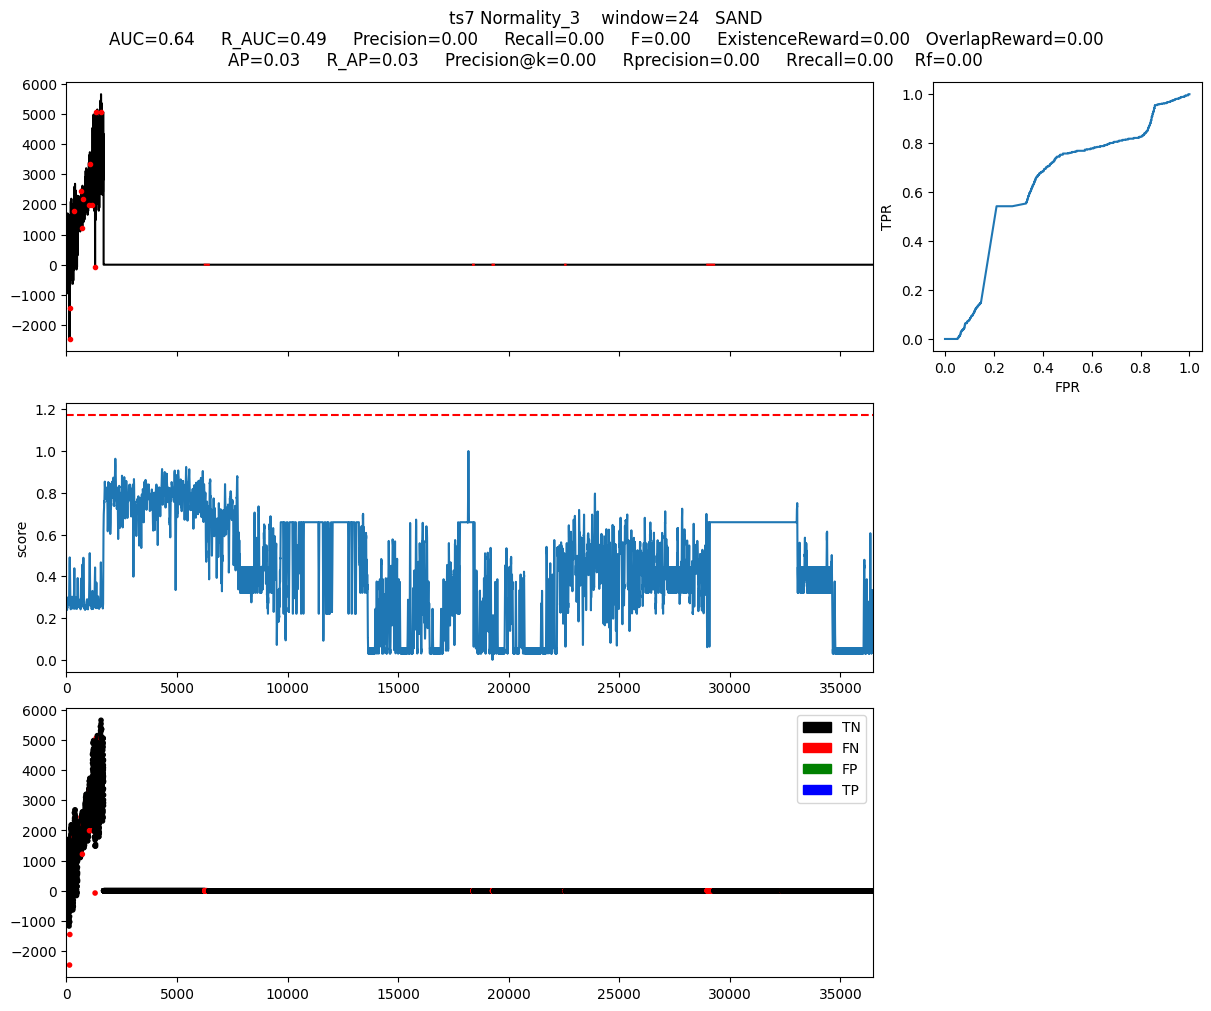

In [27]:
results = []

for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]
    x = ts['data']

    #clf = SAND(pattern_length = ts['slidingWindow'], subsequence_length = 10 * (ts['slidingWindow']))
    clf = SAND(pattern_length = ts['slidingWindow'], subsequence_length = 5 * (ts['slidingWindow']))
    #clf.fit(x, online=True, alpha=0.5, init_length = len(x), batch_size = 6000, verbose = True, overlaping_rate = (10 * (ts['slidingWindow'])) // 4)
    clf.fit(x, overlaping_rate = 5 * (ts['slidingWindow']))

    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    
    # Plot figure
    plotFig(ts['data'], ts['label'], score, ts['slidingWindow'], fileName=ts['name'] + ' ' + loaded_dict[ts['name']][0], modelName=modelName)

    # Calculate the results
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    L = [ '%.2f' % elem for elem in L]
    results.append([filename] + L)

In [13]:
columns = ['Filename'] + eval_metrics
sand_res = pd.DataFrame(results, columns=columns)

In [14]:
sand_res

,Filename,AUC,Precision,Recall,F,Rrecall,ExistenceReward,OverlapReward,Rprecision,Rf,Precision@k,R_AUC
0,ts1,0.43,0.05,0.00,0.00,0.02,0.08,0.00,0.33,0.03,0.00,0.45
1,ts3,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45
2,ts4,0.97,0.14,0.25,0.18,0.25,0.25,0.25,0.19,0.22,0.25,1.00
3,ts5,0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.61
4,ts8,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.32
5,ts2,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40
6,ts9,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29
7,ts6,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.49
8,ts7,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22


In [16]:
sand_res.to_csv('Results/SAND/SAND_Streaming.csv', index=False)

In [17]:
iforest_orig_res = pd.read_csv('Results/Isolation-Forest/IForest_Non-Streaming.csv')
iforest_stream_var1_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Naive_Variant.csv')
iforest_stream_var2_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Batch_History_Variant.csv')
iforest_stream_var3_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Dynamic_Partitioning_Variant.csv')
sand_res = pd.read_csv('Results/SAND/SAND_Streaming.csv')

filenames_col = iforest_orig_res.iloc[:,0]

iforest_orig_res = iforest_orig_res.iloc[:, 1:]
iforest_stream_var1_res = iforest_stream_var1_res.iloc[:, 1:]
iforest_stream_var2_res = iforest_stream_var2_res.iloc[:, 1:]
iforest_stream_var3_res = iforest_stream_var3_res.iloc[:, 1:]
sand_res = sand_res.iloc[:, 1:]

In [18]:
res_diff =  sand_res - iforest_stream_var3_res

res_diff.insert(0, 'Filename', filenames_col)

res_diff = res_diff.style.applymap(highlight_diff, subset=pd.IndexSlice[:, res_diff.columns[1:]])

res_diff

,Filename,AUC,Precision,Recall,F,Rrecall,ExistenceReward,OverlapReward,Rprecision,Rf,Precision@k,R_AUC
0,ts1,-0.160000,-0.310000,-0.030000,-0.050000,-0.060000,-0.250000,-0.010000,-0.260000,-0.100000,-0.030000,-0.210000
1,ts3,-0.610000,-0.990000,-0.380000,-0.550000,-0.350000,-1.000000,-0.190000,-0.670000,-0.460000,-0.380000,-0.540000
2,ts4,0.400000,0.140000,0.250000,0.180000,0.250000,0.250000,0.250000,0.190000,0.220000,0.250000,0.340000
3,ts5,-0.230000,-0.330000,-0.170000,-0.220000,-0.330000,-0.360000,-0.320000,-0.080000,-0.130000,-0.170000,-0.230000
4,ts8,-0.530000,-0.180000,-0.080000,-0.110000,-0.110000,-0.400000,-0.030000,-0.020000,-0.040000,-0.080000,-0.400000
5,ts2,-0.150000,-0.300000,-0.030000,-0.050000,-0.080000,-0.380000,-0.010000,-0.210000,-0.120000,-0.030000,-0.200000
6,ts9,-0.560000,-0.860000,-0.150000,-0.260000,-0.140000,-0.230000,-0.120000,-0.880000,-0.240000,-0.150000,-0.650000
7,ts6,-0.110000,-0.440000,-0.040000,-0.070000,-0.050000,-0.210000,-0.010000,-0.550000,-0.090000,-0.040000,-0.170000
8,ts7,-0.460000,-0.070000,-0.060000,-0.060000,-0.180000,-0.220000,-0.170000,-0.010000,-0.030000,-0.060000,-0.580000
